In [1]:
import numpy as np
from matplotlib import pyplot as plt
# import numba as nb
import os
# import ROOT
import nlfir

nlfir.py is from Jonathan Le Roy Sievers at {https://github.com/sievers/nlfir}

In [8]:
# load data

path = '/Users/yy/docu/2023 summer/bv/1/'
arr = [i for i in os.listdir(path) if i[:3]=='OF5' and i[-4:]!='root']

i = 1
path = path + arr[i]+'/'
_, path1, path0 = os.listdir(path)


/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_rdGapHighE_bunchLength5_size22/


(['configuration.txt', 'digits_out_sequence_eT.txt'],
 ['hit_eT_sig_sequence.txt',
  'digits_out_sequence_eT.txt',
  'ideal_output_sequence.txt',
  'hit_eT_bck_sequence.txt'])

In [9]:
# load data

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')     # pulse shape
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')      # simulated adc output
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')      # delta func signal
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')      # pileup noise


In [84]:
# the expected standard deviation for match filter
# we shouldnt use this in this notebook, just took it as a reference

def error_bar(pred, adc, h):
    difference = pred - adc
    noise_variance = np.mean(difference**2)
    
    denominator = np.dot(h, np.conj(h))
    
    return np.sqrt(noise_variance / denominator)

## generate Filters output and error


## Optimal

In [51]:
of_coeff = np.loadtxt(path+'1_of/configuration.txt')
of_out = np.loadtxt(path+'1_of/digits_out_sequence_eT.txt')

In [126]:

def optimal(of_out, adc, of_coeff, to_cut=int(1e6)):
    of_out = of_out[to_cut: -to_cut]
    adc = adc[to_cut: -to_cut]

    return of_out, error_bar(of_out, adc, of_coeff), of_coeff

## linear and Cubic least square

In [127]:


def lin_les(adc, signal, pileup, jl=30, jr=8, to_cut=int(1e6), thresh=1.5):
    s=signal+pileup
    k1=to_cut  #k1/k2 define the stretch of data we'll use
    k2=-k1

    ones=0.0*adc+1.0
    mat=nlfir.FIRmat(ones,0,0,k1,k2) #initialize the matrix with the constant offset term
    mat.add_vec(adc,jl,jr)  #include the linear part of the response to the ADCs
    mat.get_fts() #do this once you've added everything you want
    mat.get_coeffs(s)
    pred=mat.get_pred()

    mat.set_adjust(s,thresh)
    pred_adjust=mat.get_pred(adjust=True)[to_cut: -to_cut]

    h = np.fft.rfft(mat.coeffs)

    return pred_adjust, error_bar(pred_adjust, adc[to_cut: -to_cut], h), h
    


In [128]:


def cub_les(adc, signal, pileup, jl=30, jr=8, to_cut=int(1e6), thresh=1.5):
    s=signal+pileup
    k1=to_cut  #k1/k2 define the stretch of data we'll use
    k2=-k1

    ones=0.0*adc+1.0

    nlmat=nlfir.FIRmat(ones,0,0,k1,k2) #initialize the matrix with the constant offset term
    nlmat.add_vec(adc,jl,jr)  #include the linear part of the response to the ADCs
    nlmat.add_vec(adc**2,jl,jr)  #we can add the nonlinear part now
    nlmat.add_vec(adc**3,jl,jr) 
    nlmat.get_fts() #do this once you've added everything you want
    nlmat.get_coeffs(s)
    nlpred=nlmat.get_pred()

    nlmat.set_adjust(s,thresh)
    nlpred_adjust=nlmat.get_pred(adjust=True)[to_cut: -to_cut]

    h = np.fft.rfft(nlmat.coeffs)

    return nlpred_adjust, error_bar(nlpred_adjust, adc[to_cut: -to_cut], h), h

## Deconvolution

In [278]:
def deconv(adc, pulse=pulse, to_cut=int(1e6)):
    pp=0*adc
    pp[:len(pulse)]=pulse
    pp=np.roll(pp,0)

    pred_deco = np.fft.irfft(np.fft.rfft(adc)/np.fft.rfft(pp))[to_cut: -to_cut]
    adc = adc[to_cut: -to_cut]

    #h = np.fft.rfft(pp)
    h = np.fft.rfft(pulse)

    return pred_deco, error_bar(pred_deco, adc, h), h

## Bayes approach not here

## call above function with default data set

In [67]:
ss=(signal+pileup)

to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

In [136]:
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
deco_pred, deco_err, deco_h = deconv(adc)

diff h for deco (0.004706594970188653+0j) 26.01982839658823


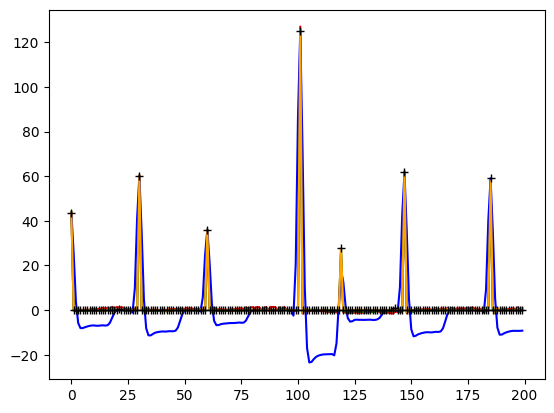

In [ ]:
# look at the signal shape

plt.plot(lin_pred[:200], 'r')
plt.plot(cub_pred[:200], 'g')
plt.plot(of_pred[5:200+5], 'b')
plt.plot(deco_pred[:200], 'orange')
plt.plot(ss[:200], 'k+')

plt.show()

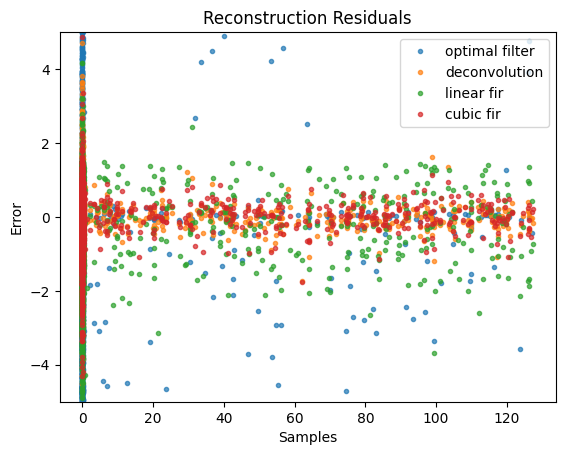

In [133]:
# look at the residual

# error shown
plt.plot(ss[20000:30000], (of_pred[5:] - ss[:-5])[10000:20000], '.', alpha=0.7)
plt.plot(ss[20000:30000], (deco_pred - ss)[10000:20000], '.', alpha=0.7)
plt.plot(ss[20000:30000], (lin_pred - ss)[10000:20000], '.', alpha=0.7)
plt.plot(ss[20000:30000], (cub_pred - ss)[10000:20000], '.', alpha=0.7)

plt.xlabel('Samples')
plt.ylabel('Error')
plt.title('Reconstruction Residuals')
plt.legend(['optimal filter', 'deconvolution', 'linear fir', 'cubic fir'])
plt.ylim(-5, 5)
plt.show()

## extract overlap signal in random freq dataset

In [160]:
def extract_overlap(signal, pulse_len=20, to_cut=int(1e6)):

    signal = signal[to_cut: -to_cut]
    sig_i = [i for i in list(range(len(signal))) if signal[i] > 0]
    overlap_i = []

    prev_i = sig_i[0]
    add_tail = False

    for i in sig_i[1:]:

        if i - prev_i < pulse_len:
            overlap_i += list(range(prev_i, i))
            add_tail = True
        elif add_tail:
            overlap_i += list(range(prev_i, prev_i+pulse_len))
            add_tail = False

        prev_i = i   

    return overlap_i

In [161]:
overlap_i = extract_overlap(signal)

non_overlap_i = np.setdiff1d( list(range(len(signal)-to_cut*2)) , overlap_i)

## analyse deltaE with diff range of Etrue

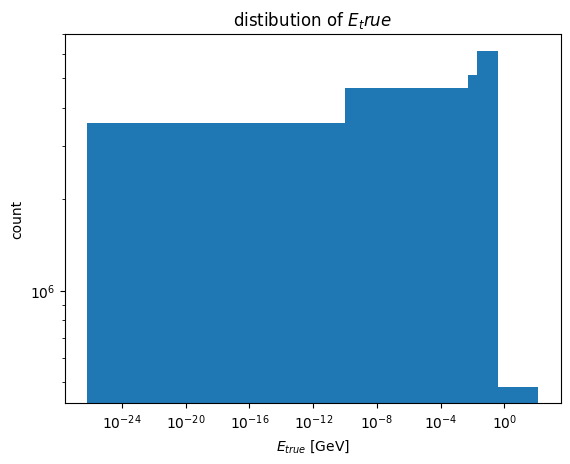

In [288]:
bins = [0, 1/1e10, 0.005, 0.02, 0.4, 130 ]
plt.hist(ss, bins=bins)
plt.yscale('log')
plt.xscale('log')

plt.xlabel('$E_{true}$ [GeV]')
plt.ylabel('count')
plt.title('distibution of $E_true$')
plt.show()

## apply functions to all five datasets

In [307]:
names = ['onlyPileup', 'constGapLowE', 'rdGapLowE', 'constGapHighE',  'rdGapHighE']

In [316]:
def plotter_tmp(ylim_l=-5, ylim_u=5):

    #plot shape
    plt.plot(lin_pred[:200], 'r')
    plt.plot(cub_pred[:200], 'orange')
    plt.plot(of_pred[5:200+5], 'b')
    plt.plot(ss[:200], 'k+')
    plt.legend(['linear fir', 'cubic fir', 'optimal filter', 'true signal'])

    plt.show()


    # error shown
    plt.plot(ss[20000:30000], (of_pred[5:] - ss[:-5])[10000:20000], '.', alpha=0.7)
    plt.plot(ss[20000:30000], (lin_pred - ss)[10000:20000], '.', alpha=0.7)
    plt.plot(ss[20000:30000], (cub_pred - ss)[10000:20000], '.', alpha=0.7)

    plt.xlabel('Samples')
    plt.ylabel('Error')
    plt.title('Reconstruction Residuals')
    plt.legend(['optimal filter', 'linear fir', 'cubic fir'])
    plt.ylim(ylim_l, ylim_u)
    plt.show()


In [311]:
i=0

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{names[i]}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')
of_out = np.loadtxt(path+path1+'/digits_out_sequence_eT.txt')


# run output
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
# deco_pred, deco_err, deco_h = deconv(adc)

# calc rms
ss=(signal+pileup)
to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_rms = np.std(of_pred-ss)
lin_rms = np.std(lin_pred-ss)
cub_rms = np.std(cub_pred-ss)

# print 
print('========',names[i],'========')
print('The expected std for linear fir, cubic fir, OF is: ')
print([lin_err, cub_err, of_err])
print('The rms for linear fir, cubic fir, OF is: ')
print([lin_rms, cub_rms, of_rms])

# prepare overlap
adc_cut = adc[to_cut: -to_cut]
overlap_i = extract_overlap(signal)
non_overlap_i = np.setdiff1d( list(range(len(signal)-to_cut*2)) , overlap_i)

overlap_of_err = error_bar(of_pred[overlap_i], adc_cut[overlap_i], of_h)
non_overlap_of_err = error_bar(of_pred[non_overlap_i], adc_cut[non_overlap_i], of_h)

overlap_lin_err = error_bar(lin_pred[overlap_i], adc_cut[overlap_i], lin_h)
non_overlap_lin_err = error_bar(lin_pred[non_overlap_i], adc_cut[non_overlap_i], lin_h)

overlap_cub_err = error_bar(cub_pred[overlap_i], adc_cut[overlap_i], cub_h)
non_overlap_cub_err = error_bar(cub_pred[non_overlap_i], adc_cut[non_overlap_i], cub_h)


print('The std for overlapped linear fir, cubic fir, OF is: ')
print([overlap_lin_err, overlap_cub_err, overlap_of_err ])
print('The std for non-overlapped linear fir, cubic fir, OF is: ')
print([non_overlap_lin_err, non_overlap_cub_err, non_overlap_of_err])

plotter_tmp(ylim_l=-1, ylim_u=1)

======== onlyPileup ========
The expected std for linear fir, cubic fir, OF is: 
[(0.08829446873655757+0j), (0.017109789312694718+0j), 0.005246827129655649]
The rms for linear fir, cubic fir, OF is: 
[0.04628198336522836, 0.041397576300995435, 0.11752994975170646]


IndexError: list index out of range

======== constGapLowE ========
The expected std for linear fir, cubic fir, OF is: 
[(0.1552141766477674+0j), (0.23519270853593868+0j), 0.0795721123221291]
The rms for linear fir, cubic fir, OF is: 
[0.24340214045083208, 0.13352188424956227, 2.4566781154686743]


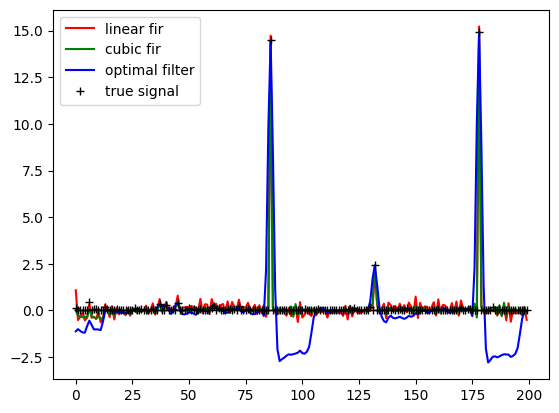

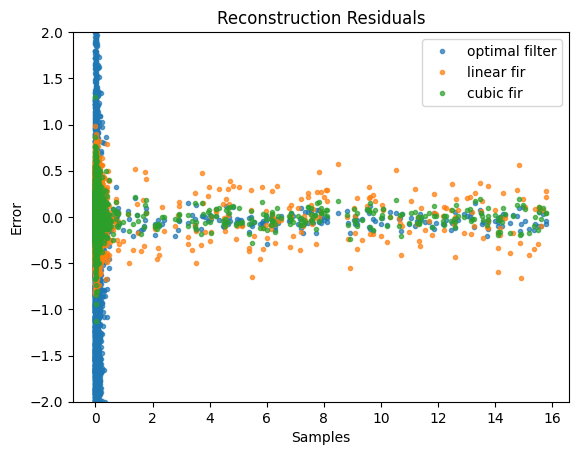

In [313]:
i=1

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{names[i]}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')
of_out = np.loadtxt(path+path1+'/digits_out_sequence_eT.txt')


# run output
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
# deco_pred, deco_err, deco_h = deconv(adc)

# calc rms
ss=(signal+pileup)
to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_rms = np.std(of_pred-ss)
lin_rms = np.std(lin_pred-ss)
cub_rms = np.std(cub_pred-ss)

# print 
print('========',names[i],'========')
print('The expected std for linear fir, cubic fir, OF is: ')
print([lin_err, cub_err, of_err])
print('The rms for linear fir, cubic fir, OF is: ')
print([lin_rms, cub_rms, of_rms])

'''# prepare overlap
adc_cut = adc[to_cut: -to_cut]
overlap_i = extract_overlap(signal)
non_overlap_i = np.setdiff1d( list(range(len(signal)-to_cut*2)) , overlap_i)

overlap_of_err = error_bar(of_pred[overlap_i], adc_cut[overlap_i], of_h)
non_overlap_of_err = error_bar(of_pred[non_overlap_i], adc_cut[non_overlap_i], of_h)

overlap_lin_err = error_bar(lin_pred[overlap_i], adc_cut[overlap_i], lin_h)
non_overlap_lin_err = error_bar(lin_pred[non_overlap_i], adc_cut[non_overlap_i], lin_h)

overlap_cub_err = error_bar(cub_pred[overlap_i], adc_cut[overlap_i], cub_h)
non_overlap_cub_err = error_bar(cub_pred[non_overlap_i], adc_cut[non_overlap_i], cub_h)


print('The std for overlapped linear fir, cubic fir, OF is: ')
print([overlap_lin_err, overlap_cub_err, overlap_of_err ])
print('The std for non-overlapped linear fir, cubic fir, OF is: ')
print([non_overlap_lin_err, non_overlap_cub_err, non_overlap_of_err])'''

plotter_tmp(ylim_l=-2, ylim_u=2)

======== rdGapLowE ========
The expected std for linear fir, cubic fir, OF is: 
[(0.18466264412302183+0j), (0.1875113959974892+0j), 0.09785874720581487]
The rms for linear fir, cubic fir, OF is: 
[0.26887069847267175, 0.1761076842629289, 3.0232206319311863]
The std for overlapped linear fir, cubic fir, OF is: 
[0.2794050063975849, 0.22588989605530652, 3.948842625773758]
The std for non-overlapped linear fir, cubic fir, OF is: 
[0.26425747200724525, 0.1648509665668348, 2.8234927554294456]


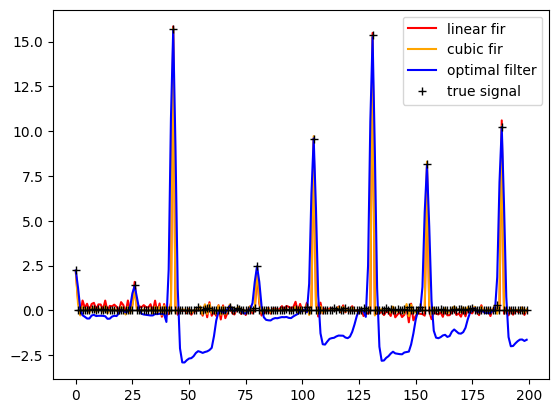

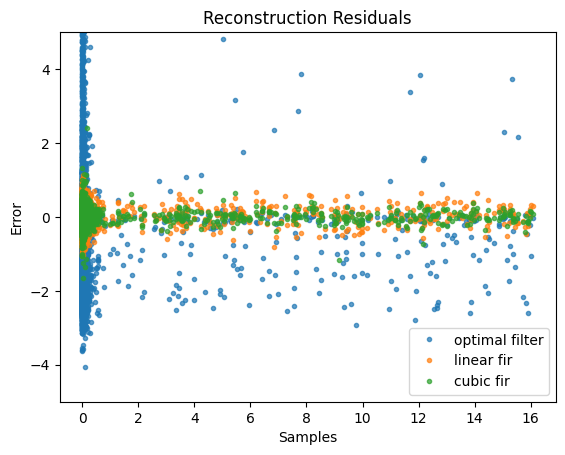

In [319]:
i=2

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{names[i]}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')
of_out = np.loadtxt(path+path1+'/digits_out_sequence_eT.txt')


# run output
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
# deco_pred, deco_err, deco_h = deconv(adc)

# calc rms
ss=(signal+pileup)
to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_rms = np.std(of_pred-ss)
lin_rms = np.std(lin_pred-ss)
cub_rms = np.std(cub_pred-ss)

# print 
print('========',names[i],'========')
print('The expected std for linear fir, cubic fir, OF is: ')
print([lin_err, cub_err, of_err])
print('The rms for linear fir, cubic fir, OF is: ')
print([lin_rms, cub_rms, of_rms])

# prepare overlap
adc_cut = adc[to_cut: -to_cut]
overlap_i = extract_overlap(signal)
non_overlap_i = np.setdiff1d( list(range(len(signal)-to_cut*2)) , overlap_i)

overlap_of_err = np.std(of_pred[overlap_i]-ss[overlap_i])
non_overlap_of_err = np.std(of_pred[non_overlap_i]-ss[non_overlap_i])

overlap_lin_err = np.std(lin_pred[overlap_i]-ss[overlap_i])
non_overlap_lin_err = np.std(lin_pred[non_overlap_i]-ss[non_overlap_i])

overlap_cub_err = np.std(cub_pred[overlap_i]-ss[overlap_i])
non_overlap_cub_err = np.std(cub_pred[non_overlap_i]-ss[non_overlap_i])


print('The std for overlapped linear fir, cubic fir, OF is: ')
print([overlap_lin_err, overlap_cub_err, overlap_of_err ])
print('The std for non-overlapped linear fir, cubic fir, OF is: ')
print([non_overlap_lin_err, non_overlap_cub_err, non_overlap_of_err])

plotter_tmp()

======== constGapHighE ========
The expected std for linear fir, cubic fir, OF is: 
[(1.0839035133185086+0j), (0.7964771547946048+0j), 0.6349514564014707]
The rms for linear fir, cubic fir, OF is: 
[0.8100988390522595, 0.3169737844788943, 19.623499585202815]


/Users/yy/opt/anaconda3/envs/cern2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/yy/opt/anaconda3/envs/cern2/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


The std for overlapped linear fir, cubic fir, OF is: 
[(nan+nanj), (nan+nanj), nan]
The std for non-overlapped linear fir, cubic fir, OF is: 
[(1.0839035133185086+0j), (0.7964771547946048+0j), 0.6349514564014707]


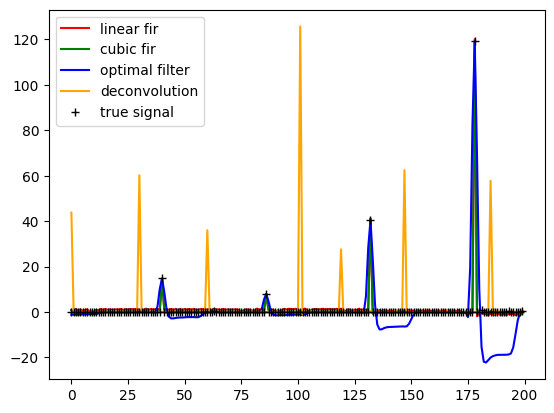

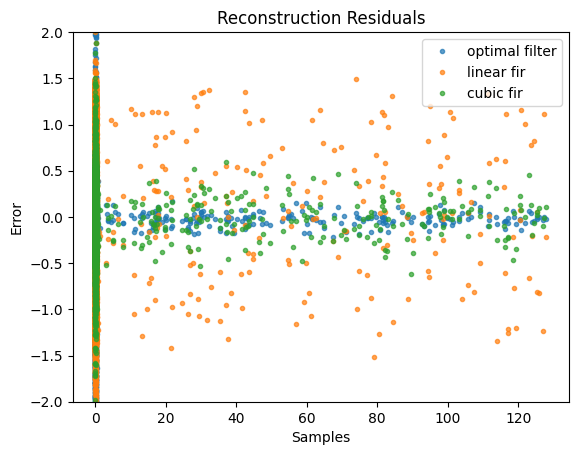

In [309]:
i=3

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{names[i]}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')
of_out = np.loadtxt(path+path1+'/digits_out_sequence_eT.txt')


# run output
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
# deco_pred, deco_err, deco_h = deconv(adc)

# calc rms
ss=(signal+pileup)
to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_rms = np.std(of_pred-ss)
lin_rms = np.std(lin_pred-ss)
cub_rms = np.std(cub_pred-ss)

# print 
print('========',names[i],'========')
print('The expected std for linear fir, cubic fir, OF is: ')
print([lin_err, cub_err, of_err])
print('The rms for linear fir, cubic fir, OF is: ')
print([lin_rms, cub_rms, of_rms])


plotter_tmp(ylim_l=-2, ylim_u=2)

======== rdGapHighE ========
The expected std for linear fir, cubic fir, OF is: 
[(1.2522659416185122+0j), (0.88041579251543+0j), 0.7817160499671794]
The rms for linear fir, cubic fir, OF is: 
[1.037201459085269, 0.4699099195110815, 24.167115063043767]
The std for overlapped linear fir, cubic fir, OF is: 
[1.2626881892053168, 0.6532232732970173, 31.520334499590028]
The std for non-overlapped linear fir, cubic fir, OF is: 
[0.9574792727274073, 0.40872354455355764, 22.582087944261453]


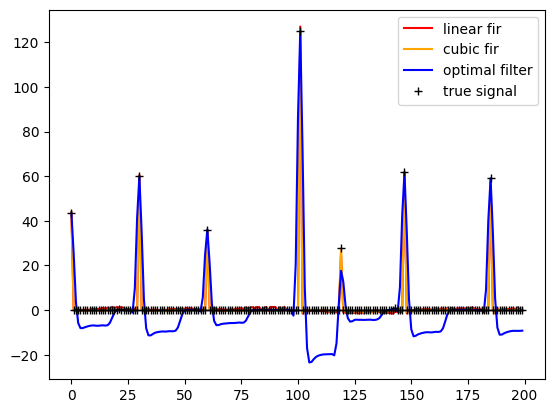

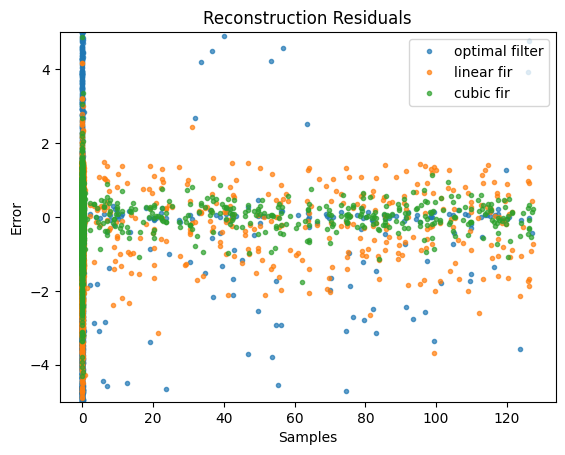

In [320]:
i=4

# load files
path = f'/Users/yy/docu/2023 summer/bv/1/OF5_EMB_EMMiddle_eta0.5125_phi0.0125_mu140_BT1_{names[i]}_bunchLength5_size22/'
_, path1, path0 = os.listdir(path)

pulse = np.loadtxt(path+path0+'/ideal_output_sequence.txt')
adc = np.loadtxt(path+path0+'/digits_out_sequence_eT.txt')
signal = np.loadtxt(path+path0+'/hit_eT_sig_sequence.txt')
pileup = np.loadtxt(path+path0+'/hit_eT_bck_sequence.txt')
of_out = np.loadtxt(path+path1+'/digits_out_sequence_eT.txt')


# run output
of_pred, of_err, of_h = optimal(of_out, adc, of_coeff)
lin_pred, lin_err, lin_h = lin_les(adc, signal, pileup)
cub_pred, cub_err, cub_h = cub_les(adc, signal, pileup)
# deco_pred, deco_err, deco_h = deconv(adc)

# calc rms
ss=(signal+pileup)
to_cut=int(1e6)
ss = ss[to_cut: -to_cut]

of_rms = np.std(of_pred-ss)
lin_rms = np.std(lin_pred-ss)
cub_rms = np.std(cub_pred-ss)

# print 
print('========',names[i],'========')
print('The expected std for linear fir, cubic fir, OF is: ')
print([lin_err, cub_err, of_err])
print('The rms for linear fir, cubic fir, OF is: ')
print([lin_rms, cub_rms, of_rms])

# prepare overlap
adc_cut = adc[to_cut: -to_cut]
overlap_i = extract_overlap(signal)
non_overlap_i = np.setdiff1d( list(range(len(signal)-to_cut*2)) , overlap_i)

overlap_of_err = np.std(of_pred[overlap_i]-ss[overlap_i])
non_overlap_of_err = np.std(of_pred[non_overlap_i]-ss[non_overlap_i])

overlap_lin_err = np.std(lin_pred[overlap_i]-ss[overlap_i])
non_overlap_lin_err = np.std(lin_pred[non_overlap_i]-ss[non_overlap_i])

overlap_cub_err = np.std(cub_pred[overlap_i]-ss[overlap_i])
non_overlap_cub_err = np.std(cub_pred[non_overlap_i]-ss[non_overlap_i])


print('The std for overlapped linear fir, cubic fir, OF is: ')
print([overlap_lin_err, overlap_cub_err, overlap_of_err ])
print('The std for non-overlapped linear fir, cubic fir, OF is: ')
print([non_overlap_lin_err, non_overlap_cub_err, non_overlap_of_err])

plotter_tmp()